In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.models.mlp import MLPScoreModel
from score_models.trainer import trainer
from score_models.train_steps import TrainStepDenoisingScoreMatching
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas

%load_ext autoreload
%autoreload 2

In [2]:
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
input_size = 2
hidden_size = 32
L = 10
lr = 5e-4

sigma_min = 1.0
sigma_max = 20.0

device = "cuda"

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, L=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# define train step (i.e., criterion)
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepDenoisingScoreMatching(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=10_000,
    log_every=1000,
)

  0%|          | 7/10000 [00:00<08:00, 20.79it/s]

Step 0, Loss: 24.0247


 10%|█         | 1009/10000 [00:21<03:12, 46.75it/s]

Step 1000, Loss: 0.3193


 20%|██        | 2007/10000 [00:42<02:48, 47.38it/s]

Step 2000, Loss: 0.2897


 30%|███       | 3007/10000 [01:04<02:28, 47.00it/s]

Step 3000, Loss: 0.2639


 40%|████      | 4010/10000 [01:25<02:06, 47.36it/s]

Step 4000, Loss: 0.2580


 50%|█████     | 5010/10000 [01:45<01:45, 47.23it/s]

Step 5000, Loss: 0.2797


 60%|██████    | 6010/10000 [02:06<01:27, 45.74it/s]

Step 6000, Loss: 0.2292


 70%|███████   | 7006/10000 [02:28<01:04, 46.22it/s]

Step 7000, Loss: 0.2184


 80%|████████  | 8008/10000 [02:49<00:40, 48.74it/s]

Step 8000, Loss: 0.2466


 90%|█████████ | 9010/10000 [03:10<00:20, 47.36it/s]

Step 9000, Loss: 0.2527


100%|██████████| 10000/10000 [03:31<00:00, 47.18it/s]


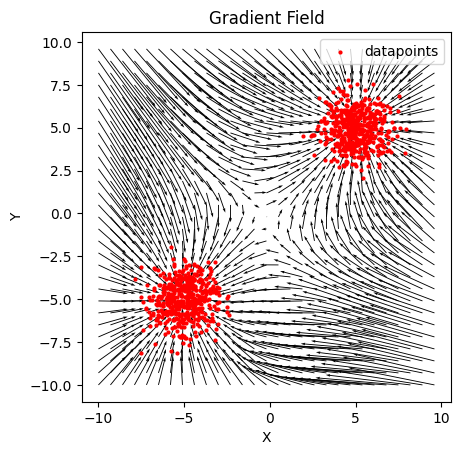

In [5]:
from score_models.utils.visualisations import plot_gradient_field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000])

In [6]:
from score_models.sampling import annealed_langevin_dynamics

samples = annealed_langevin_dynamics(
    score_model=score_model, input_size=(500, 2), sigmas=sigmas, r=(-8, 8)
).cpu().numpy()

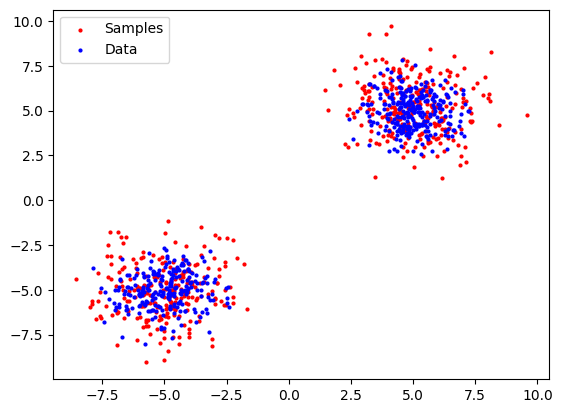

In [7]:
import matplotlib.pyplot as plt

ax = plt.gca()
ax.scatter(
    samples[:, 0], samples[:, 1], color='red', s=4, label='Samples'
)
ax.scatter(
    dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data'
)
plt.legend();